In [1]:
from common.data import *
from common.model import *
import os
import cv2
from skimage.filters import threshold_otsu
import tensorflow as tf
from tqdm import tqdm

Using TensorFlow backend.
/Users/AR3/anaconda3/envs/YKDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/AR3/anaconda3/envs/YKDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/AR3/anaconda3/envs/YKDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/AR3/anaconda3/envs/YKDL/l

In [2]:
#set path
current_path=os.getcwd()
train_im_path=os.path.join(current_path, "im_for_model", "train_im")
train_ground_truth_im_path=os.path.join(current_path, "im_for_model", "train_gt")
validation_im_path=os.path.join(current_path, "im_for_model", "val_im")
validation_ground_truth_im_path=os.path.join(current_path, "im_for_model", "val_gt")
test_im_path=os.path.join(current_path, "im_for_model", "test_im")
test_ori_im_path=os.path.join(current_path, "im_for_model", "test_ori_im")
test_angle_im_path=os.path.join(current_path, "im_for_model", "test_angle_im")

trained_model_path=os.path.join(current_path, "trained_model")
npz_path=os.path.join(current_path, "npz_file")
pred_im_path=os.path.join(npz_path, "pred_im")

for path in [trained_model_path, npz_path, pred_im_path]:
    if os.path.exists(path)==False:
        os.makedirs(path)

### Training : data generator with an augmentation

In [3]:
# augmentation dictionary
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

#first input: batch size
#second input: path to train images
#third input: path to ground truth images
#fourth input; args 
myGene = trainGenerator(4, train_im_path, train_ground_truth_im_path, data_gen_args)

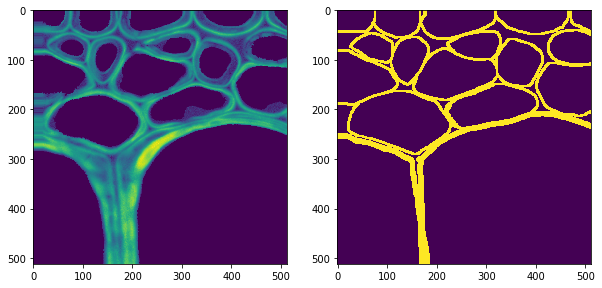

In [4]:
# check the augmentation
num_batch = 2
for i,batch in enumerate(myGene):
    if(i >= num_batch):
        break

i = 1
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(batch[0][i][:,:,0])
ax[1].imshow(batch[1][i][:,:,0])
plt.show()
plt.close()

In [5]:
# load validation data
vali_test, vali_label = geneNpy(validation_im_path, validation_ground_truth_im_path)

In [6]:
# start to train U-net model
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(5, train_im_path, train_ground_truth_im_path, data_gen_args)
model = unet()
model_checkpoint = ModelCheckpoint(os.path.join(trained_model_path, "trained_model.hdf5"), monitor='val_loss', 
                                   verbose=1, save_best_only=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit_generator(myGene, steps_per_epoch=100, epochs=50, callbacks=[model_checkpoint, callback], 
                             validation_data=(vali_test, vali_label))

Epoch 1/50
100/100 [==============================] - 86s 861ms/step - loss: 1.1589 - acc: 0.8641 - DiceBCELoss: 1.1589 - val_loss: 1.1303 - val_acc: 0.8377 - val_DiceBCELoss: 1.1303

Epoch 00001: val_loss improved from inf to 1.13033, saving model to /Volumes/G-SPEED3/AR3/YK2021-2025/data_for_2nd_paper_Titis/20230302_Unet/trained_model/trained_model.hdf5
Epoch 2/50
100/100 [==============================] - 80s 795ms/step - loss: 1.0393 - acc: 0.8834 - DiceBCELoss: 1.0393 - val_loss: 1.0685 - val_acc: 0.8614 - val_DiceBCELoss: 1.0685

Epoch 00002: val_loss improved from 1.13033 to 1.06847, saving model to /Volumes/G-SPEED3/AR3/YK2021-2025/data_for_2nd_paper_Titis/20230302_Unet/trained_model/trained_model.hdf5
Epoch 3/50
100/100 [==============================] - 80s 804ms/step - loss: 0.9972 - acc: 0.8945 - DiceBCELoss: 0.9972 - val_loss: 1.0159 - val_acc: 0.8849 - val_DiceBCELoss: 1.0159

Epoch 00003: val_loss improved from 1.06847 to 1.01591, saving model to /Volumes/G-SPEED3/AR3/YK

### Plot the history of training

In [7]:
#save training history as csv
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

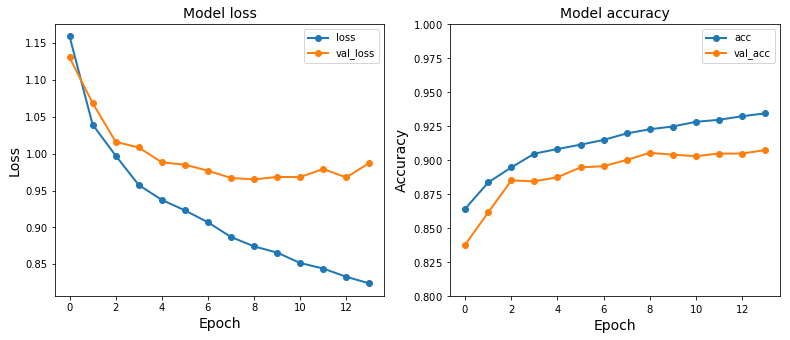

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(history.history['loss'],'-o',linewidth=2.0,label='loss')
ax[0].plot(history.history['val_loss'],'-o',linewidth=2.0,label='val_loss')
ax[0].set_title('Model loss', fontsize =14)
ax[0].set_ylabel('Loss', fontsize =14)
ax[0].set_xlabel('Epoch', fontsize =14)
ax[0].legend()

ax[1].plot(history.history['acc'],'-o',linewidth=2.0,label='acc')
ax[1].plot(history.history['val_acc'],'-o',linewidth=2.0,label='val_acc')
ax[1].set_title('Model accuracy', fontsize =14)
ax[1].set_ylabel('Accuracy', fontsize =14)
ax[1].set_xlabel('Epoch', fontsize =14)
ax[1].set_ylim(0.80, 1.0)
ax[1].ticklabel_format(useMathText=True)
ax[1].legend()

plt.show()
plt.close()
#plt.savefig("model result", dpi=600)

### Predict image

In [9]:
#get path to test images for prediction
test_im_list=[]
for curdir, _, files in os.walk(test_im_path):
    if len(files)>0:
        test_im_list_temp=[]
        for file in files:
            target_path=os.path.join(curdir, file)
            test_im_list_temp.append(target_path)
        test_im_list.append(test_im_list_temp)
        
test_ori_im_list=[]
for curdir, _, files in os.walk(test_ori_im_path):
    if len(files)>0:
        test_ori_im_list_temp=[]
        for file in files:
            target_path=os.path.join(curdir, file)
            target_im=cv2.imread(target_path, -1)
            test_ori_im_list_temp.append(target_im)
        test_ori_im_list.append(test_ori_im_list_temp)
        
test_angle_im_list=[]
for curdir, _, files in os.walk(test_angle_im_path):
    if len(files)>0:
        test_angle_im_list_temp=[]
        for file in files:
            target_path=os.path.join(curdir, file)
            target_im=cv2.imread(target_path, -1)
            test_angle_im_list_temp.append(target_im)
        test_angle_im_list.append(test_angle_im_list_temp)

0it [00:00, ?it/s]/Users/AR3/anaconda3/envs/YKDL/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/AR3/anaconda3/envs/YKDL/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


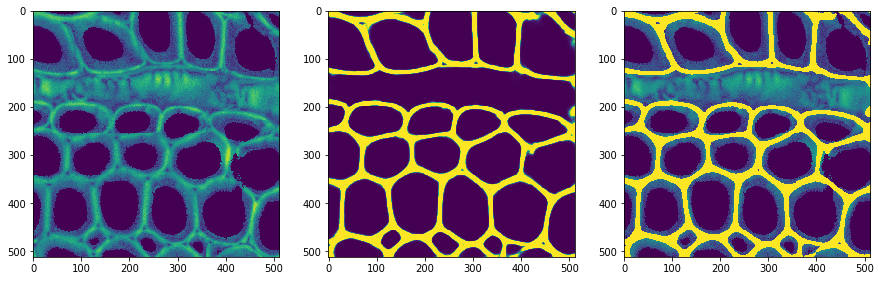

1it [00:24, 24.54s/it]

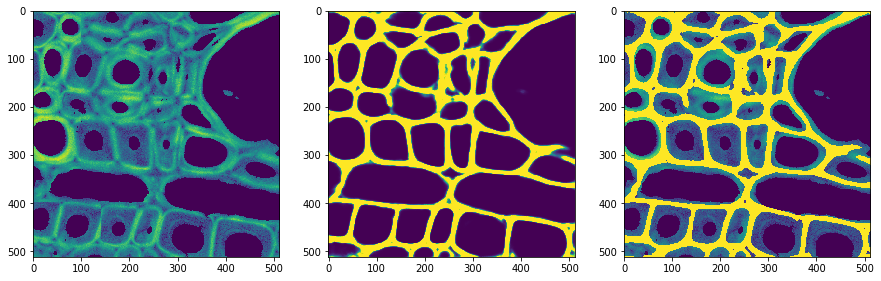

2it [00:49, 24.77s/it]

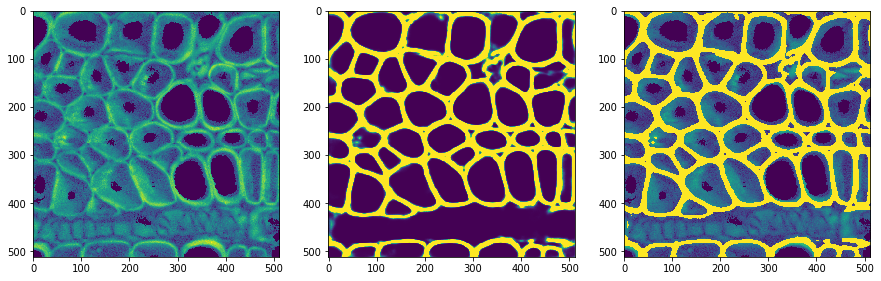

3it [01:17, 25.59s/it]

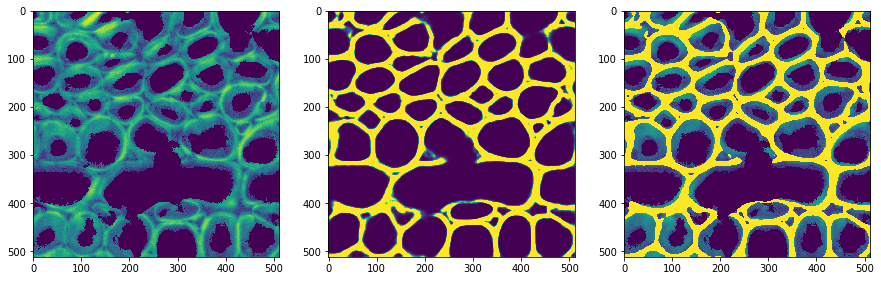

4it [01:42, 25.48s/it]

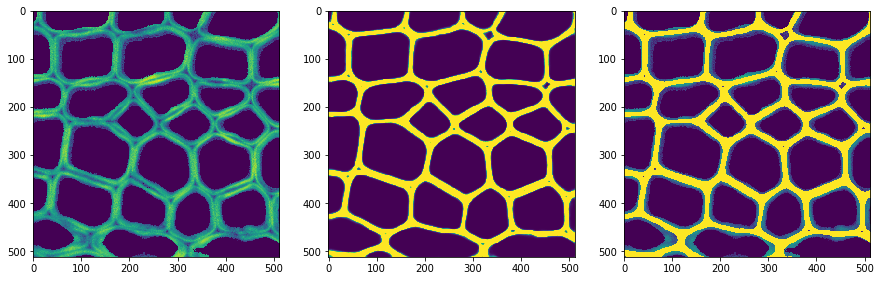

5it [02:07, 25.24s/it]

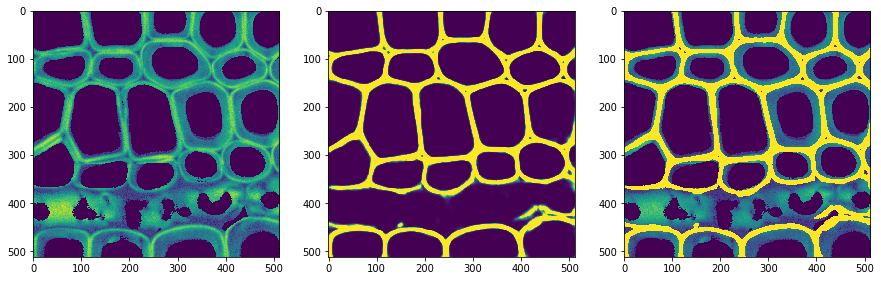

6it [02:33, 25.48s/it]

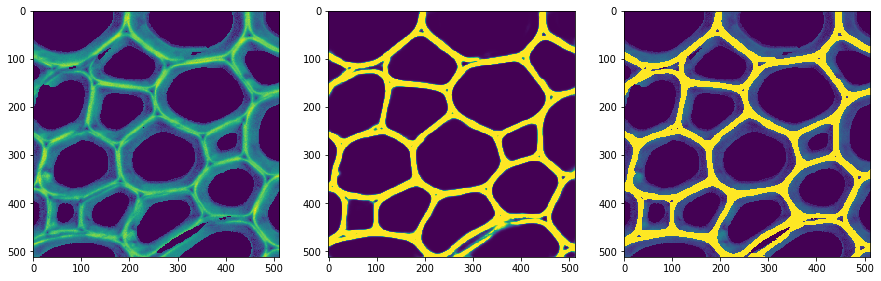

7it [02:58, 25.52s/it]

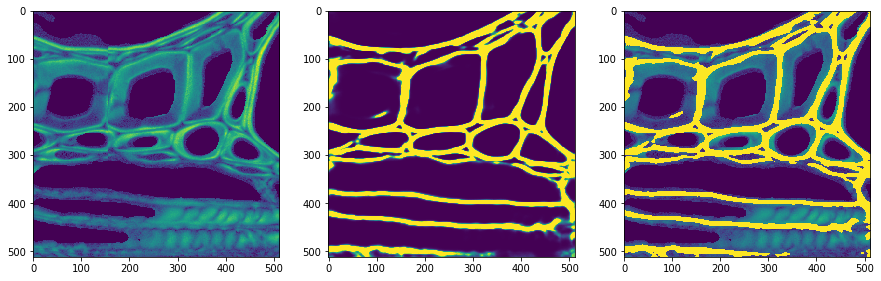

8it [03:23, 25.22s/it]

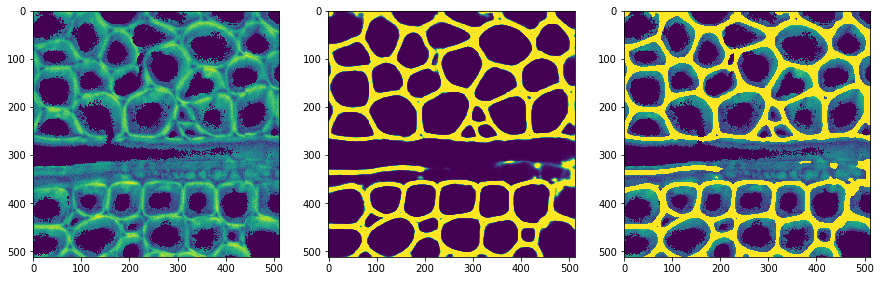

9it [03:38, 22.04s/it]

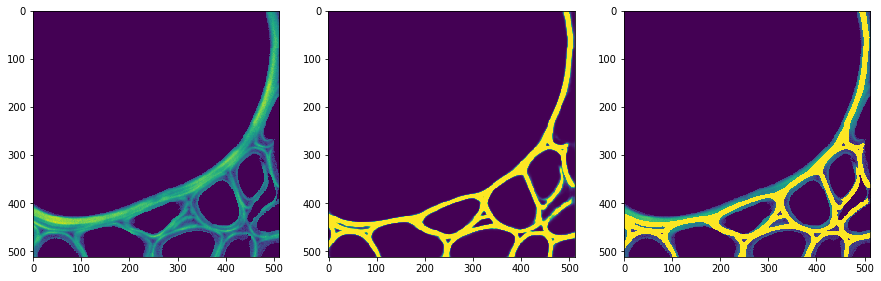

10it [04:03, 23.19s/it]

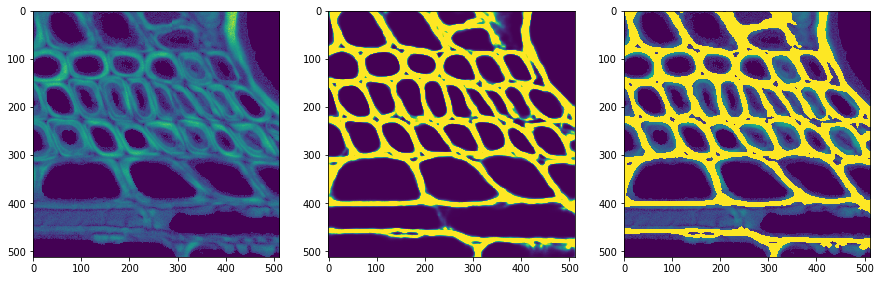

11it [04:34, 25.51s/it]

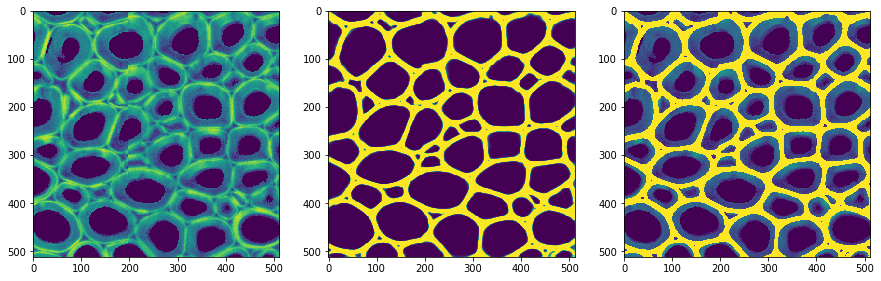

12it [05:10, 28.43s/it]

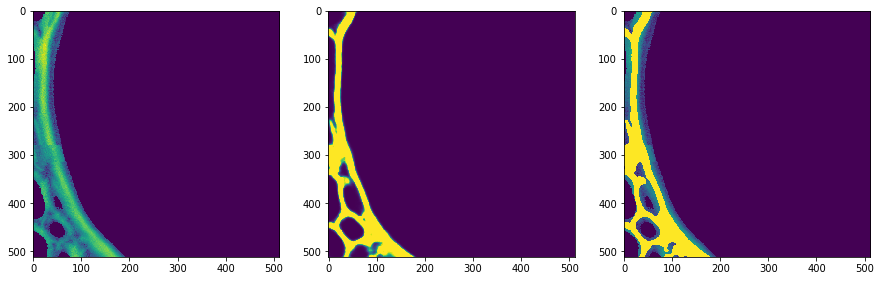

13it [05:37, 28.03s/it]

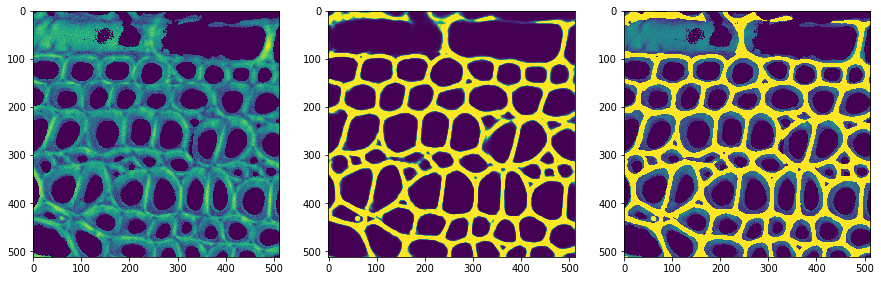

14it [06:09, 29.22s/it]

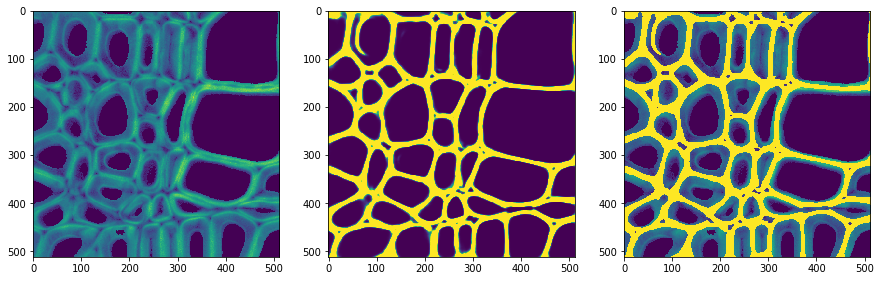

15it [06:34, 27.95s/it]

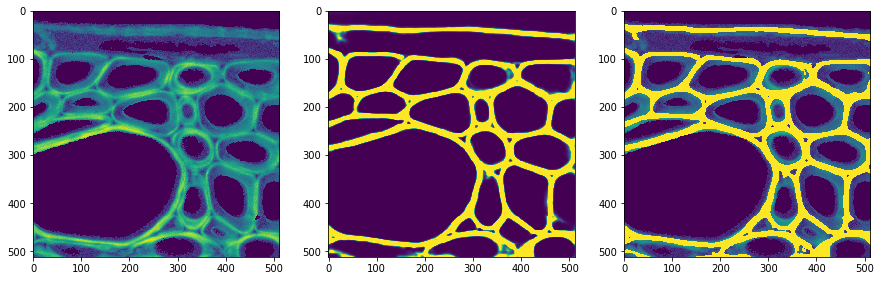

16it [07:03, 28.33s/it]

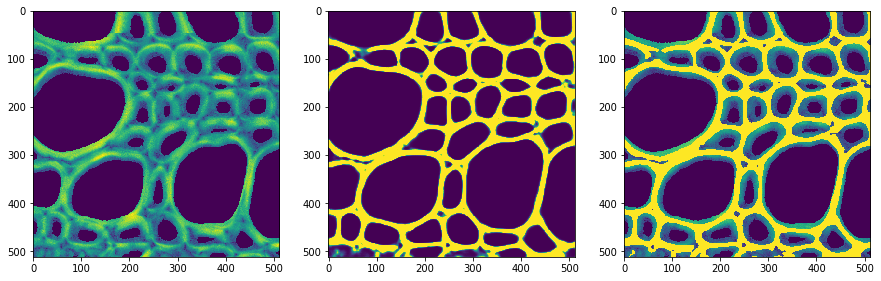

17it [07:25, 26.50s/it]

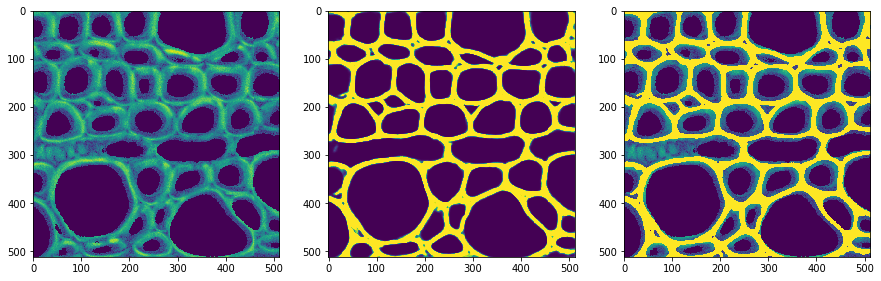

18it [07:44, 24.32s/it]

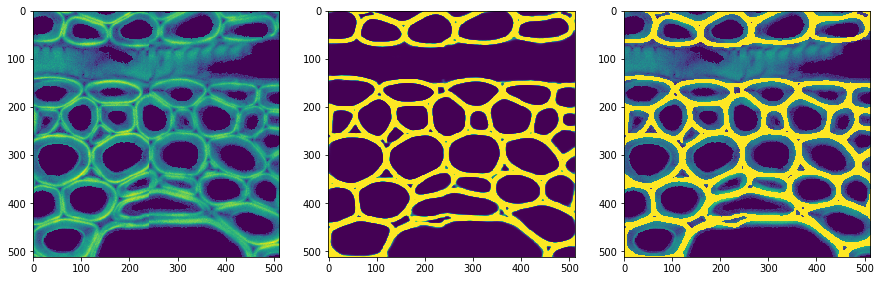

19it [08:25, 29.33s/it]

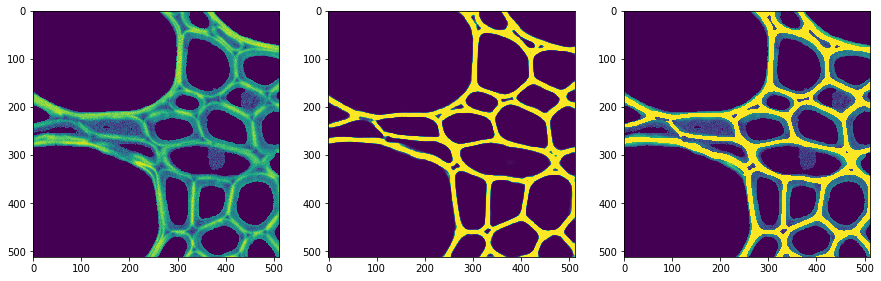

20it [08:54, 29.14s/it]

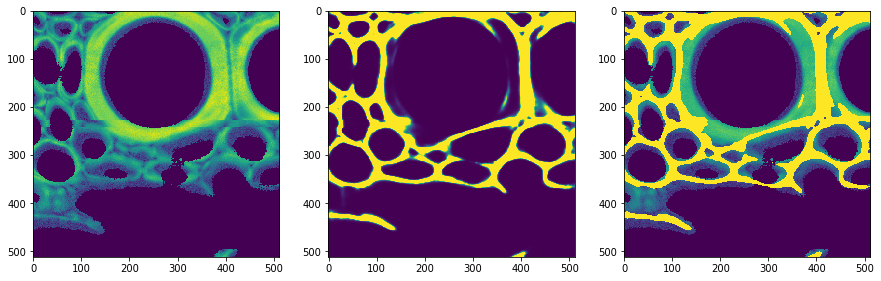

21it [09:21, 28.35s/it]

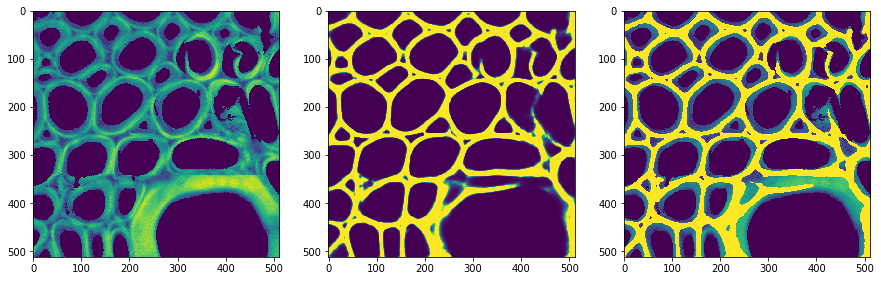

22it [09:49, 28.33s/it]

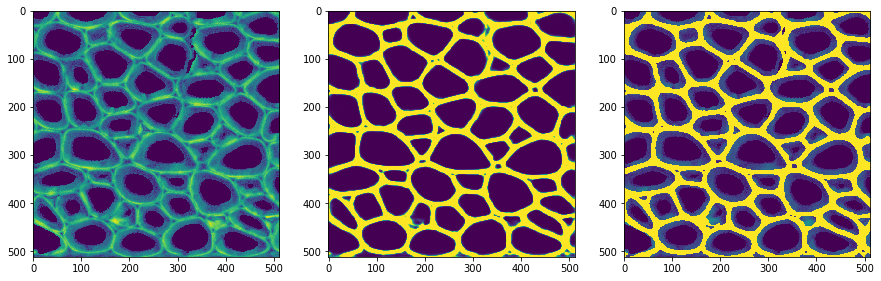

23it [10:07, 25.25s/it]

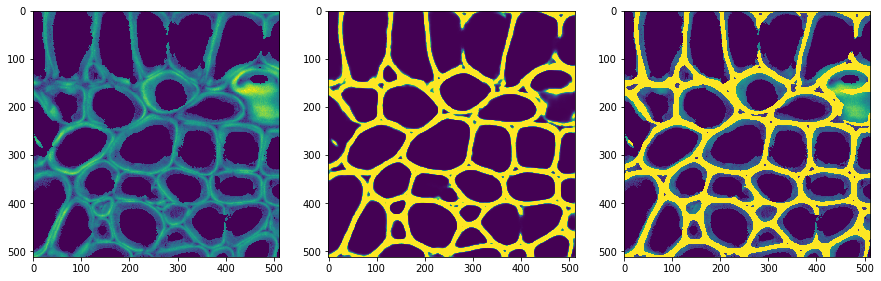

24it [10:24, 22.76s/it]

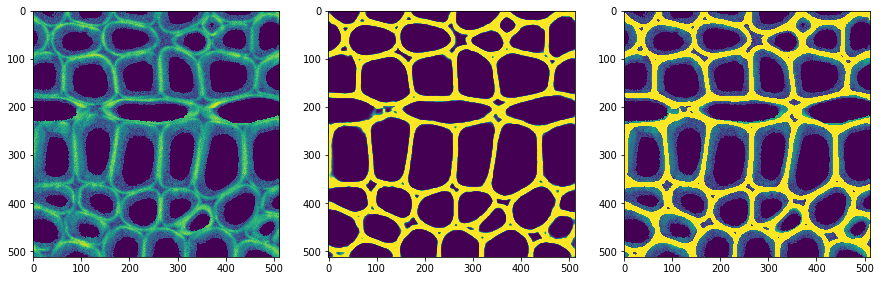

25it [10:47, 23.01s/it]

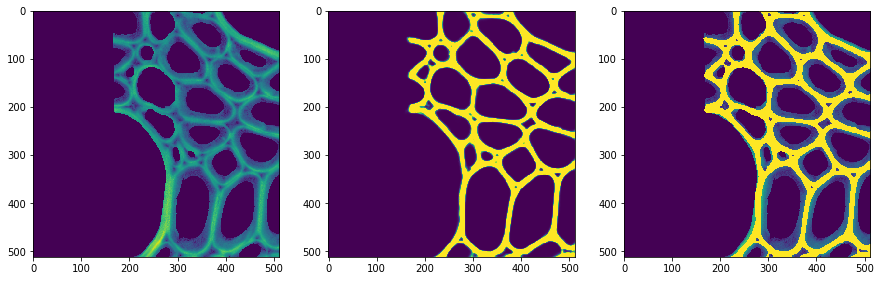

26it [11:19, 25.65s/it]

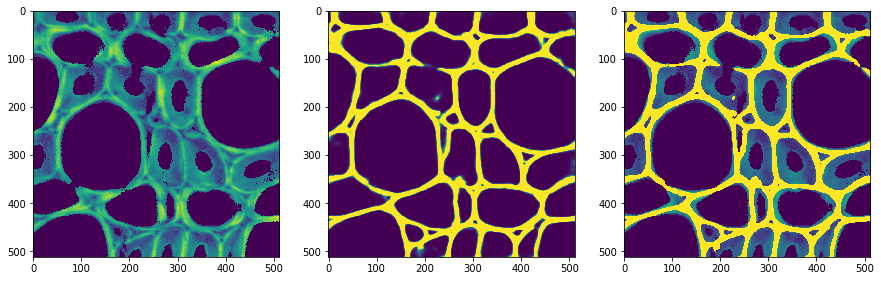

27it [11:38, 23.59s/it]

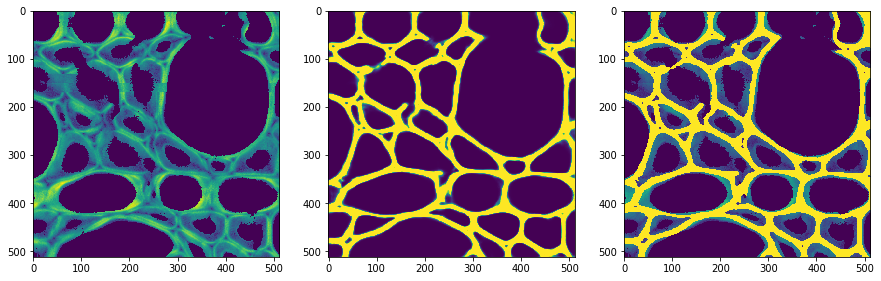

28it [12:02, 23.85s/it]

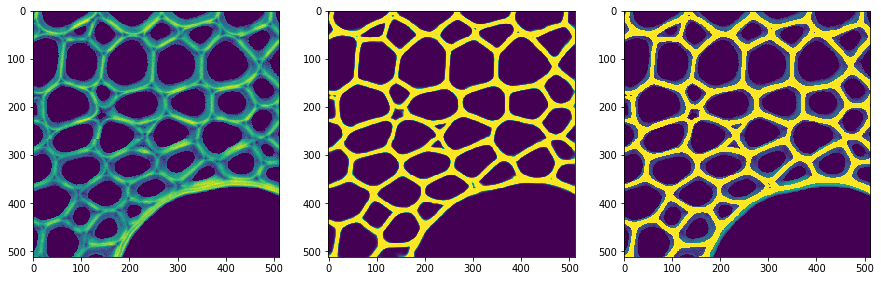

29it [12:25, 23.48s/it]

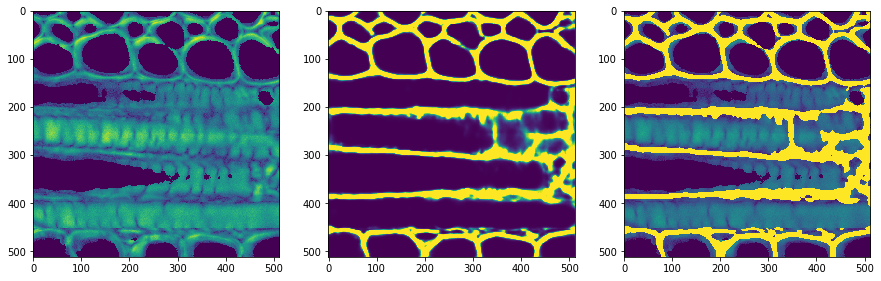

30it [12:50, 23.91s/it]

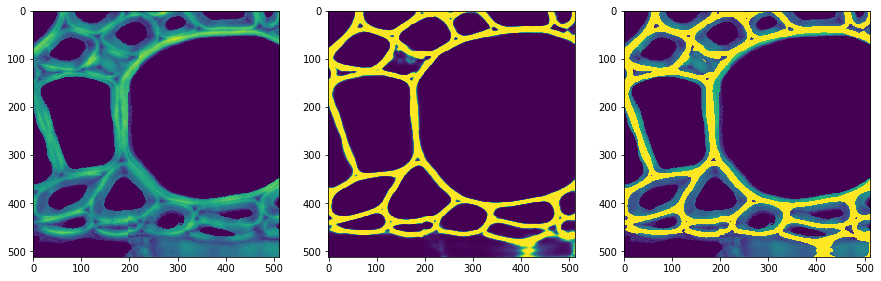

31it [13:19, 25.35s/it]

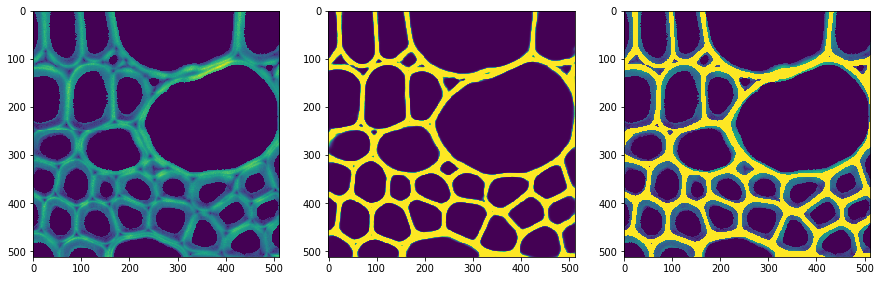

32it [13:43, 25.18s/it]


In [10]:
#prediction and save results
for num, test_im_file_path in tqdm(enumerate(test_im_list)):
    #get height and width information from file names
    height_num=0
    width_num=0
    for i in range(len(test_im_file_path)):
        height_num_temp=os.path.splitext(os.path.basename(test_im_file_path[i]))[0].split("_")[-2]
        width_num_temp=os.path.splitext(os.path.basename(test_im_file_path[i]))[0].split("_")[-1]

        #update height num
        if int(height_num_temp) > int(height_num):
            height_num=int(height_num_temp)
        else:
            pass

        #update width num
        if int(width_num_temp) > int(width_num):
            width_num=int(width_num_temp)
        else:
            pass
        
    
    #prediction
    testGene = testGenerator_path(test_im_file_path)
    model = unet()
    model.load_weights(os.path.join(trained_model_path, "trained_model.hdf5"))
    results = model.predict_generator(testGene, len(test_im_file_path))
    
    #compare the result of test image and prediction
    i = height_num*width_num//2
    #load image
    ori_im=cv2.imread(test_im_file_path[i], -1)
    #ori_im=cv2.cvtColor(ori_im, cv2.COLOR_BGR2RGB)

    #binarization
    thresh = threshold_otsu(results[i][:,:,0])
    binary = (results[i][:,:,0] > thresh)*255
    compare_im=np.where(binary==0, ori_im, 255)

    fig,ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(ori_im)
    ax[1].imshow(results[i][:,:,0])
    ax[2].imshow(compare_im)
    #fig.colorbar(im, ax=ax[1])
    plt.show()
    plt.close()
    
    sample_name=os.path.splitext(os.path.basename(test_im_file_path[i]))[0][:-8]
    np.savez_compressed(os.path.join(pred_im_path, str(sample_name)+".npz"), pred_im=results,
                        ori_im=test_ori_im_list[num], angle_im=test_angle_im_list[num],
                        height_num=height_num, width_num=width_num)